In [1]:
import pandas as pd
from pprint import pprint

In [2]:
df_train = pd.read_json('../../data/wish_products_truetag_tahoe/Wish_Truetag_Tahoe_Meta_Train_OpenaiReverseCreated.json', lines=True)
df_train_remapped =  pd.read_json('../../data/wish_products_truetag_tahoe/Wish_Truetag_Tahoe_Meta_Train_OpenaiReverseCreated_AddedInferredTrueTag.json', lines=True)

In [3]:
df_train['category'] = df_train['category'].apply(tuple)

In [4]:
df_train_remapped['category'] = df_train_remapped['category'].apply(tuple)
df_train_remapped['openai_truetag_category'] = df_train_remapped['openai_truetag_category'].apply(tuple)

In [5]:
len(set(df_train['category'])), len(set(df_train_remapped['category']))

(5291, 5291)

In [6]:
df_truetag = pd.read_json('../../data/wish_products_truetag_tahoe/true_tag_info.json', lines=True)

In [7]:
truetag_set = set(df_truetag['category'].apply(tuple))

In [8]:
len(df_train_remapped) / len(df_train)

0.9999664692825098

In [9]:
len(set(df_train_remapped['openai_truetag_category']).intersection(truetag_set)) / len(truetag_set)

0.5892857142857143

In [10]:
from collections import Counter

In [11]:
df_train_remapped.head(2)

,title,category,text,openai_truetag_category
0,"Boys' Leather Belt, Ratchet Automatic Buckle B...","(apparel accessories, boys' accessories, boys'...","Boys' Leather Belt, Ratchet Automatic Buckle B...","(accessories, belts)"
1,"Boys Blue Light Blocking Glasses, Anti Blue Ra...","(apparel accessories, boys' accessories, boys'...","Boys Blue Light Blocking Glasses, Anti Blue Ra...","(eyewear, glasses)"


In [12]:
len(df_train_remapped) / len(set(df_train_remapped.category))

28.182196182196183

In [13]:
# x generations per newtax leaf node, if x-1 of them are not within truetag_set, then 
# we are really uncertain of the correcteness of the leftover 1 that is in truetag set

uncertainty = 1 / (len(df_train_remapped) / len(set(df_train_remapped.category)) - 1)

def tags2prob(tags):
    cnt = {i: 0 for i in truetag_set} # .01 for smoothing
    cnt['unk'] = 0 # add unknown too
    for i in tags:
        if i in truetag_set:
            cnt[i] += 1
        else:
            cnt['unk'] += uncertainty
    denom = 0
    for i in cnt:
        denom += cnt[i]
    probs = {}
    for i in cnt:
        probs[i] = cnt[i] / denom 
    probs = probs.items()
    probs = sorted(probs, key=lambda x: -x[1])
    probs = probs[:3]
    probs = [i for i in probs if i[1] > 0]
    return probs

In [14]:
df_map = df_train_remapped.groupby('category').agg(
    truetag_probs = ('openai_truetag_category', tags2prob),
    support = ('openai_truetag_category', len),
).reset_index()

In [15]:
df_map

,category,truetag_probs,support
0,"(apparel accessories, boys' accessories, boys'...","[((accessories, belts), 1.0)]",29
1,"(apparel accessories, boys' accessories, boys'...","[((accessories, glasses), 0.3841547292478558),...",29
2,"(apparel accessories, boys' accessories, boys'...","[(unk, 0.5074100332569552), ((glasses, accesso...",29
3,"(apparel accessories, boys' accessories, boys'...","[((accessories, sunglasses), 0.951044216207482...",29
4,"(apparel accessories, boys' accessories, boys'...","[((accessories, gloves), 0.909694467676722), (...",29
...,...,...,...
5286,"(women's clothing, women's exotic apparel, lin...","[((fashion, lingerie), 0.5511523456960444), ((...",28
5287,"(women's clothing, women's exotic apparel, pan...","[((fashion, underwear), 0.6906910079686804), (...",27
5288,"(women's clothing, women's exotic apparel, pants)","[((fashion, bottoms), 0.40959007102701533), ((...",28
5289,"(women's clothing, women's exotic apparel, tanks)","[((fashion, tops), 0.25805542895899347), ((top...",28


In [16]:
df_map_conf = df_map[df_map.truetag_probs.apply(lambda x: x[0][0] != 'unk')]

In [17]:
len(df_map_conf) / len(df_map)

0.9474579474579474

In [18]:
len(df_map_conf[df_map_conf.truetag_probs.apply(lambda x: x[0][1]) > .5]) / len(df_map)

0.41315441315441315

In [19]:
df_map_conf_high = df_map_conf[df_map_conf.truetag_probs.apply(lambda x: x[0][1]) > .5]

In [20]:
len(set(df_map_conf.truetag_probs.apply(lambda x: x[0][0]))) / len(truetag_set)

0.34546703296703296

In [21]:
Counter([i[0] for i in (truetag_set - set(df_map_conf.truetag_probs.apply(lambda x: x[0][0])))]).most_common(10)

[('gadgets', 73),
 ('hobbies', 35),
 ('makeup & beauty', 34),
 ('parts & accessories', 25),
 ('baby & kids', 24),
 ('dresses', 23),
 ('weapons', 23),
 ('accessories', 22),
 ('tops', 22),
 ('fashion', 21)]

In [22]:
df_map_conf.truetag_probs.apply(lambda x: x[0][0][0] == 'gadgets').sum()

566

In [23]:
pprint(
    df_map_conf[df_map_conf.truetag_probs.apply(lambda x: x[0][0][0] == 'gadgets')].sample(5).to_dict('records')
)

[{'category': ('consumer electronics',
               'sports & action video cameras',
               'sports camcorder accessories'),
  'support': 28,
  'truetag_probs': [(('gadgets', 'camera accessories'), 0.614385106540523),
                    (('gadgets', 'memory cards'), 0.20479503551350767),
                    ('unk', 0.18081985794596928)]},
 {'category': ('home improvement',
               'lights & lighting',
               'lighting accessories',
               'starters'),
  'support': 29,
  'truetag_probs': [(('gadgets', 'led lights'), 0.5099498988877057),
                    (('fashion', 'underwear'), 0.16998329962923522),
                    (('parts & accessories', 'automotive', 'car accessories'),
                     0.16998329962923522)]},
 {'category': ('consumer electronics',
               'portable audio & video',
               'mp3 / mp4 player accessories',
               'mp3 / mp4 player cable'),
  'support': 28,
  'truetag_probs': [(('gadgets', 'computer ac

<AxesSubplot: ylabel='Frequency'>

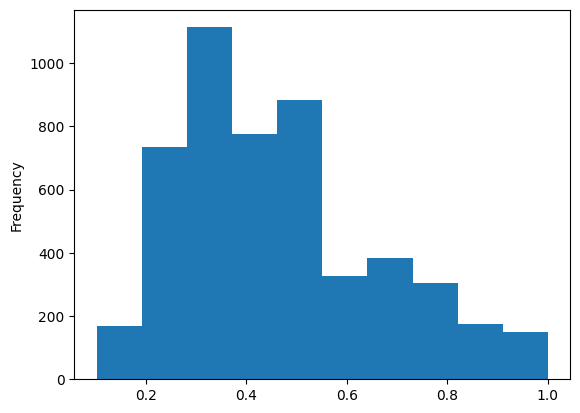

In [24]:
df_map_conf.truetag_probs.apply(lambda x: x[0][1]).plot.hist()

In [25]:
(df_map_conf.truetag_probs.apply(lambda x: x[0][1]) > .5).mean()

0.4360662278077

In [26]:
pprint(df_map_conf[(df_map_conf.truetag_probs.apply(lambda x: x[0][1]) > .5)].sample(5).to_dict('records'))

[{'category': ('consumer electronics',
               'camera & photo',
               'camera replacement parts',
               'flash parts'),
  'support': 28,
  'truetag_probs': [(('gadgets', 'camera accessories'), 0.5102405727483335),
                    (('home decor', 'clocks'), 0.2551202863741667),
                    ('unk', 0.23463914087749976)]},
 {'category': ('jewelry & accessories',
               'customized jewelry',
               'customized bracelets'),
  'support': 29,
  'truetag_probs': [(('accessories', 'bracelets'), 0.549758966084194),
                    (('accessories', 'jewelry'), 0.3435993538026212),
                    (('jewelry', 'accessories', 'sterling silver jewelry'),
                     0.06871987076052424)]},
 {'category': ('home & garden', 'pet products', 'dog grooming', 'dog scissors'),
  'support': 28,
  'truetag_probs': [(('hobbies', 'sewing & knitting supplies'),
                     0.5016813288776957),
                    ('unk', 0.4983186711

In [27]:
pprint(df_map_conf[(df_map_conf.truetag_probs.apply(lambda x: x[0][1]) < .2)].sample(5).to_dict('records'))

[{'category': ('beauty & health',
               'sexual wellness',
               'sex toys',
               'vagina balls'),
  'support': 29,
  'truetag_probs': [(('accessories', 'beads'), 0.14606766678278604),
                    (('gadgets', 'led lights'), 0.14606766678278604),
                    (('sexual wellness', 'dildos'), 0.14606766678278604)]},
 {'category': ('automobiles & motorcycles',
               'atv,rv,boat & other vehicle',
               'aviation parts & accessories'),
  'support': 28,
  'truetag_probs': [(('computer accessories', 'gadgets', 'mouse pads'),
                     0.17105297586340595),
                    (('sexual wellness', 'vibrators'), 0.17105297586340595),
                    (('parts & accessories',
                      'automotive',
                      'car & truck parts & accessories'),
                     0.17105297586340595)]},
 {'category': ('automobiles & motorcycles',
               'car repair tools',
               'sheet metal too

In [28]:
df_map_conf['top_true_tag'] = df_map_conf['truetag_probs'].apply(lambda x: x[0][0])

/tmp/ipykernel_3611/3323138739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map_conf['top_true_tag'] = df_map_conf['truetag_probs'].apply(lambda x: x[0][0])


In [29]:
Counter(df_map_conf['top_true_tag']).most_common(10)

[(('home decor', 'kitchen'), 334),
 (('automotive', 'parts & accessories'), 232),
 (('hobbies', 'tools'), 172),
 (('hobbies', 'outdoor & camping accessories'), 159),
 (('automotive', 'automotive tools & supplies'), 124),
 (('home decor', 'bathroom'), 109),
 (('baby & kids', 'kids'), 107),
 (('household supplies', 'cleaning supplies'), 99),
 (('hobbies', 'stationery'), 98),
 (('accessories', 'jewelry'), 90)]

In [44]:
len(set(df_map_conf['category'])), len(set(df_train_remapped['category']))

(5013, 5291)

In [43]:
len(set(df_map_conf_high['category'])), len(set(df_train_remapped['category']))

(2186, 5291)

In [34]:
df_map_conf_high['top_true_tag'] = df_map_conf_high['truetag_probs'].apply(lambda x: x[0][0])

/tmp/ipykernel_3611/4260992682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map_conf_high['top_true_tag'] = df_map_conf_high['truetag_probs'].apply(lambda x: x[0][0])


In [35]:
truetag2newtax = {}
for i in df_map_conf_high.to_dict('records'):
    if i['top_true_tag'] not in truetag2newtax:
        truetag2newtax[i['top_true_tag']] = {}
    if i['category'] not in truetag2newtax[i['top_true_tag']]:
        truetag2newtax[i['top_true_tag']][i['category']] = 1
    else:
        truetag2newtax[i['top_true_tag']][i['category']] += 1

In [36]:
truetag2newtax_all = {}
for i in df_map_conf.to_dict('records'):
    if i['top_true_tag'] not in truetag2newtax_all:
        truetag2newtax_all[i['top_true_tag']] = {}
    if i['category'] not in truetag2newtax_all[i['top_true_tag']]:
        truetag2newtax_all[i['top_true_tag']][i['category']] = 1
    else:
        truetag2newtax_all[i['top_true_tag']][i['category']] += 1

In [37]:
len(truetag2newtax), len(df_map_conf_high)

(335, 2186)

In [38]:
len(truetag2newtax_all), len(df_map_conf)

(503, 5013)

In [39]:
len(truetag_set)

1456

In [40]:
pprint(truetag2newtax)

{('accessories', 'arm warmers'): {('apparel accessories', "men's accessories", "men's arm warmers"): 1,
                                  ('sports', 'fishing', 'fishing apparel', 'fishing arm sleeve'): 1,
                                  ('sports', 'running', 'running arm warmers'): 1,
                                  ('sports', 'sports accessories', 'sports safety', 'arm warmers'): 1},
 ('accessories', 'badges'): {('education & office supplies', 'labels, indexes & stamps', 'badge holder & accessories'): 1},
 ('accessories', 'belts'): {('apparel accessories', "boys' accessories", "boys' belts"): 1,
                            ('apparel accessories', "girls' accessories", "girls' belts"): 1,
                            ('apparel accessories', "men's belts"): 1,
                            ('apparel accessories', "women's belts"): 1,
                            ('beauty & health', 'health care', 'household health monitors', 'kidney belt'): 1,
                            ('sports', 'fis